## Problem Statement

#### Forecast the CocaCola prices data set.

### Import all the required libraries 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx",sheet_name='Sheet1')
df=df.set_index('Quarter')
df.head()

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, Q1_86 to Q2_96
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   42 non-null     float64
dtypes: float64(1)
memory usage: 672.0+ bytes


In [4]:
df.index

Index(['Q1_86', 'Q2_86', 'Q3_86', 'Q4_86', 'Q1_87', 'Q2_87', 'Q3_87', 'Q4_87',
       'Q1_88', 'Q2_88', 'Q3_88', 'Q4_88', 'Q1_89', 'Q2_89', 'Q3_89', 'Q4_89',
       'Q1_90', 'Q2_90', 'Q3_90', 'Q4_90', 'Q1_91', 'Q2_91', 'Q3_91', 'Q4_91',
       'Q1_92', 'Q2_92', 'Q3_92', 'Q4_92', 'Q1_93', 'Q2_93', 'Q3_93', 'Q4_93',
       'Q1_94', 'Q2_94', 'Q3_94', 'Q4_94', 'Q1_95', 'Q2_95', 'Q3_95', 'Q4_95',
       'Q1_96', 'Q2_96'],
      dtype='object', name='Quarter')

In [5]:
df.index = df.index.str.replace(r'(Q\d)_(\d+)', r'\2-\1')
df.head()

,Sales
Quarter,
86-Q1,1734.827000
86-Q2,2244.960999
86-Q3,2533.804993
86-Q4,2154.962997
87-Q1,1547.818996


In [6]:
df.index = pd.PeriodIndex(df.index, freq='Q').to_timestamp()
df.head()

,Sales
Quarter,
2086-01-01,1734.827000
2086-04-01,2244.960999
2086-07-01,2533.804993
2086-10-01,2154.962997
2087-01-01,1547.818996


In [7]:
df.index

DatetimeIndex(['2086-01-01', '2086-04-01', '2086-07-01', '2086-10-01',
               '2087-01-01', '2087-04-01', '2087-07-01', '2087-10-01',
               '2088-01-01', '2088-04-01', '2088-07-01', '2088-10-01',
               '2089-01-01', '2089-04-01', '2089-07-01', '2089-10-01',
               '2090-01-01', '2090-04-01', '2090-07-01', '2090-10-01',
               '2091-01-01', '2091-04-01', '2091-07-01', '2091-10-01',
               '2092-01-01', '2092-04-01', '2092-07-01', '2092-10-01',
               '2093-01-01', '2093-04-01', '2093-07-01', '2093-10-01',
               '2094-01-01', '2094-04-01', '2094-07-01', '2094-10-01',
               '2095-01-01', '2095-04-01', '2095-07-01', '2095-10-01',
               '2096-01-01', '2096-04-01'],
              dtype='datetime64[ns]', name='Quarter', freq='QS-OCT')

### Time Series Analysis

<AxesSubplot: xlabel='Quarter'>

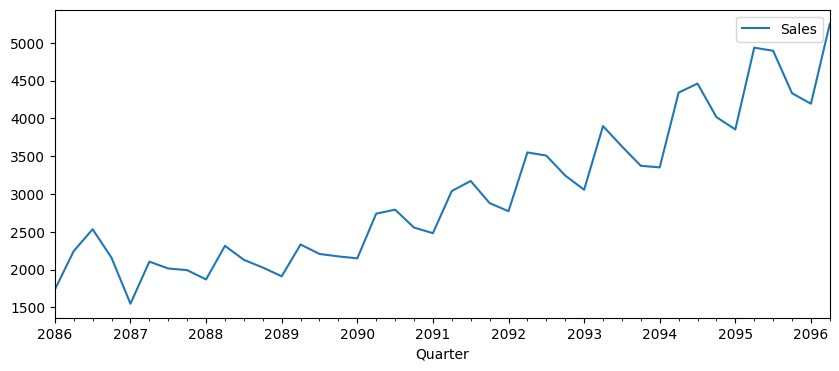

In [8]:
## Line Plot
df.plot(figsize=(10,4))

array([[<AxesSubplot: title={'center': 'Sales'}>]], dtype=object)

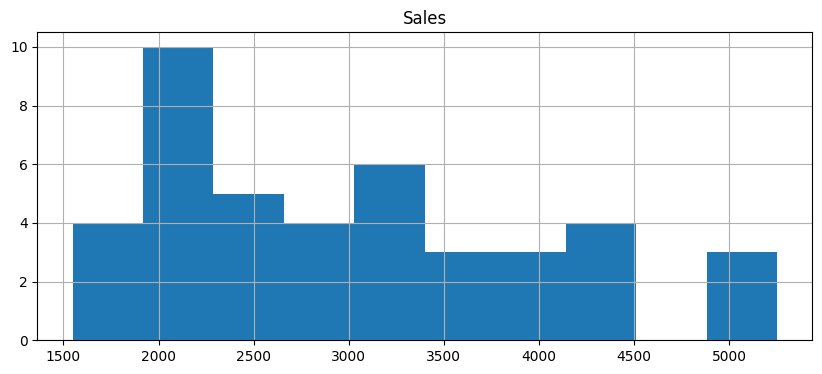

In [9]:
# Histogram
df.hist(figsize=(10,4))

<AxesSubplot: ylabel='Density'>

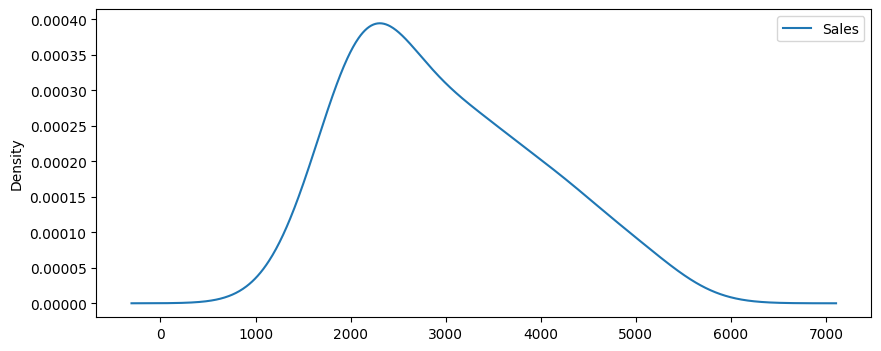

In [10]:
## Density Plot
df.plot(kind='kde',figsize=(10,4))

### Time series decomposition

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Additive seasonal decompose 

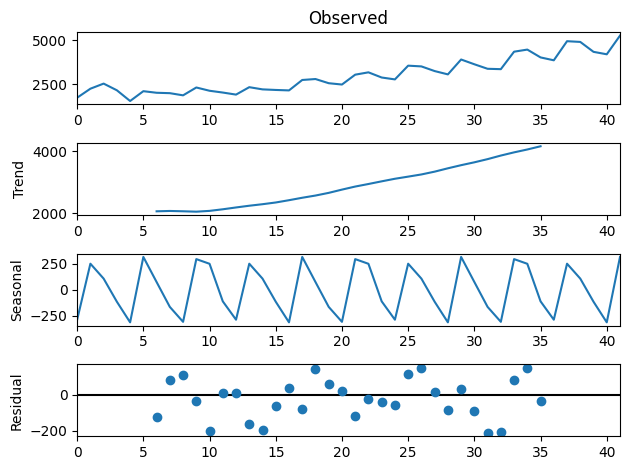

In [12]:
# frequency=4 for quarterly data
ts_decomp= seasonal_decompose((df.values),model='additive',period=12)
ts_plot = ts_decomp.plot()

### Multiplicative seasonal decompose

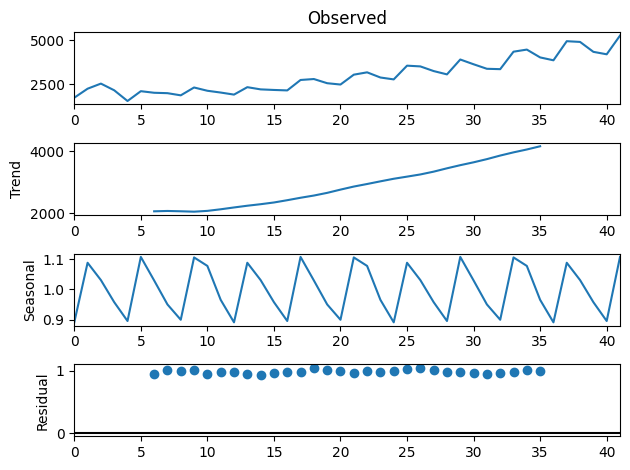

In [13]:
# frequency=4 for quarterly data
ts_decomp_mul= seasonal_decompose((df.values),model='multiplicative',period=12)
ts_plot_mul = ts_decomp_mul.plot()

### Forecasting models building

In [14]:
## Splitting into train and test data
df_train=df[0:28]
df_test=df[28:]

In [15]:
print("Total records in train set:",len(df_train))
print("Total records in test set:",len(df_test))


Total records in train set: 28
Total records in test set: 14


### Simple Moving Average

In [16]:
df_ma=df.copy()

In [17]:
train_len=28

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
roll_val=[]
rmse_val=[]

for i in range(4,28,4):
    df_ma['ma_forecast'] = df_ma['Sales'].rolling(i).mean()
    df_ma['ma_forecast'][train_len:] = df_ma['ma_forecast'][train_len-1]
    rmse_ma = mean_squared_error(df_test['Sales'],df_ma['ma_forecast'][train_len:],squared=False).round(2)
    roll_val.append(i)
    rmse_val.append(rmse_ma)


In [20]:
df1=pd.DataFrame({'Rolling window':roll_val,'rmse':rmse_val})
df1

,Rolling window,rmse
0,4,1049.59
1,8,1205.98
2,12,1357.90
3,16,1527.27
4,20,1643.99
5,24,1749.03


In [21]:
df_ma['ma_forecast'] = df_ma['Sales'].rolling(4).mean()
df_ma['ma_forecast'][train_len:] = df_ma['ma_forecast'][train_len-1]
rmse_ma = mean_squared_error(df_test['Sales'],df_ma['ma_forecast'][train_len:],squared=False).round(2)
rmse_ma

1049.59

### Simple Exponential Smoothing

In [22]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [23]:
ses_model = SimpleExpSmoothing(df_train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = df_test.index[0],end = df_test.index[-1])

In [24]:
rmse_ses = mean_squared_error(df_test['Sales'],pred_ses,squared=False).round(2)
rmse_ses

1225.36

### Holt's Method 

In [25]:
from statsmodels.tsa.holtwinters import Holt

In [26]:
holt_model = Holt(df_train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_holt = holt_model.predict(start = df_test.index[0],end = df_test.index[-1])

In [27]:
rmse_holt = mean_squared_error(df_test['Sales'],pred_holt,squared=False).round(2)
rmse_holt

538.41

### Holt's Exponential Smoothing

### Additive Method

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [33]:
hes_add_add = ExponentialSmoothing(df_train['Sales'],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hes_add_add = hes_add_add.predict(start = df_test.index[0],end = df_test.index[-1])

In [34]:
rmse_hes_add_add = mean_squared_error(df_test['Sales'],pred_hes_add_add,squared=False).round(2)
rmse_hes_add_add

431.44

### Multiplicative Method 

In [35]:
hes_mul_add = ExponentialSmoothing(df_train['Sales'],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hes_mul_add = hes_mul_add.predict(start = df_test.index[0],end = df_test.index[-1])

In [36]:
rmse_hes_mul_add = mean_squared_error(df_test['Sales'],pred_hes_mul_add,squared=False).round(2)
rmse_hes_mul_add

603.07

### ARIMA model

### ACF Plot

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

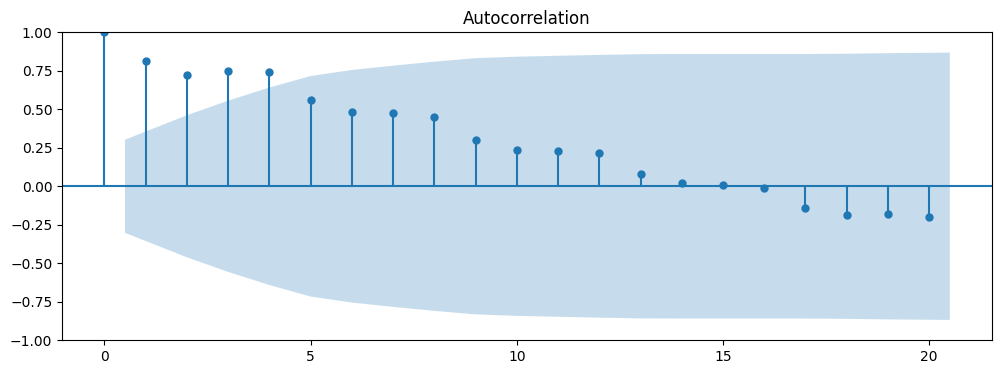

In [38]:
# Show autocorrelation upto lag 20
plt.figure(figsize=(12,4))
acf_plot = plot_acf( df['Sales'],ax=plt.gca(),lags=20)
plt.show()

### PCF Plot 

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

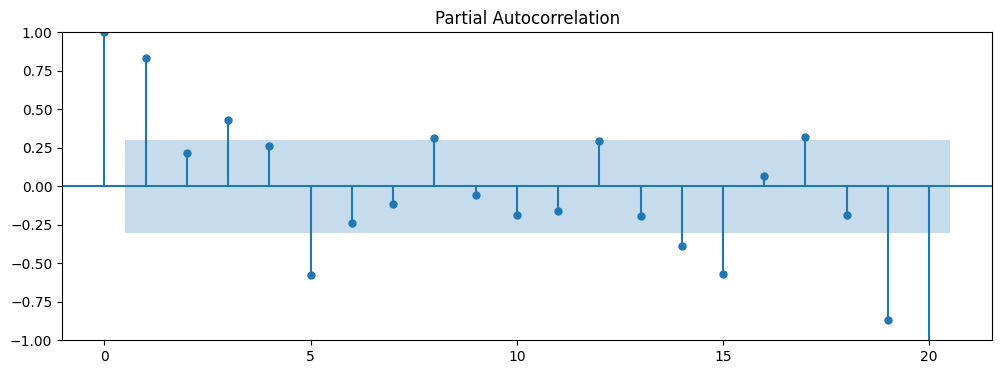

In [40]:
plt.figure(figsize=(12,4))
pacf_plot = plot_pacf( df['Sales'],ax=plt.gca(),lags=20)
plt.show()

In [41]:
from statsmodels.tsa.arima.model import ARIMA

In [42]:
arima = ARIMA(df_train['Sales'], order=(1,1,1)).fit()
pred_arima= arima.predict(start = df_test.index[0],end = df_test.index[-1])

In [43]:
rmse_arima = mean_squared_error(df_test['Sales'],pred_arima,squared=False).round(2)
rmse_arima

1062.27

### Resulting Model Comparison

In [44]:
models=['simple_moving_average','simple_expo_smoothing','Holt','Holt_additive','Holt_multiplicative','ARIMA']
rmse=[rmse_ma,rmse_ses,rmse_holt,rmse_hes_add_add,rmse_hes_mul_add,rmse_arima]
d={'Models':models,'Rmse':rmse}
df_model=pd.DataFrame(d)
df_model

,Models,Rmse
0,simple_moving_average,1049.59
1,simple_expo_smoothing,1225.36
2,Holt,538.41
3,Holt_additive,431.44
4,Holt_multiplicative,603.07
5,ARIMA,1062.27


In [45]:
df_model.sort_values(by='Rmse')

,Models,Rmse
3,Holt_additive,431.44
2,Holt,538.41
4,Holt_multiplicative,603.07
0,simple_moving_average,1049.59
5,ARIMA,1062.27
1,simple_expo_smoothing,1225.36


### So Holt's model is the best one as it has the lowest rmse of all models.